**Step 1: Collect Historical Stock Data (SPY Closing Prices)
and Step 2: Select the Feature to Predict**


In [ ]:
# Step 1: Collect Historical Stock Data
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd

# Download SPY data (S&P 500 ETF)
df = yf.download("SPY", start="2015-01-01", end="2024-12-31")

# Keep only the 'Close' price
df = df[['Close']]

# Display the first few rows
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,SPY
Date,
2015-01-02,172.075195
2015-01-05,168.967621
2015-01-06,167.376129
2015-01-07,169.461792
2015-01-08,172.468903


The first step in building our stock prediction model is to collect historical data that the model will learn from. In our case, we chose SPY, an ETF that tracks the S&P 500, because it provides a good representation of the overall stock market. Using the Python yfinance library, we downloaded daily stock data for SPY from 2015 to the end of 2024. We only kept the 'Close' column, since that’s the price we want to predict.

In code, this was done by calling the yfinance.download() function and selecting just the 'Close' prices from the result.

The second step is about deciding what exactly we want the model to predict. Stock data includes different features like opening price, highest price, volume, etc., but we’re focusing only on the closing price. The closing price reflects the final value of the stock at the end of each trading day and is commonly used in stock analysis and forecasting. Since we already filtered the data to keep only the 'Close' column, this step is essentially complete.

**Step 3: Prepare the Data**

In [ ]:
# Step 3: Prepare the Data

# Ensure it's sorted
df = df.sort_index()

# Reset index (optional, but keeps things clean)
df.reset_index(drop=True, inplace=True)

# Convert to NumPy array for modeling
data = df['Close'].values
data = data.reshape(-1, 1)  # reshape for scaling

print(f"Shape of data: {data.shape}")


Shape of data: (2515, 1)


We clean and format the raw stock data to make it suitable for modeling. This includes sorting, reshaping, and ensuring the structure is ready for scaling and training.

**Step 3.1: Visualize the Data**

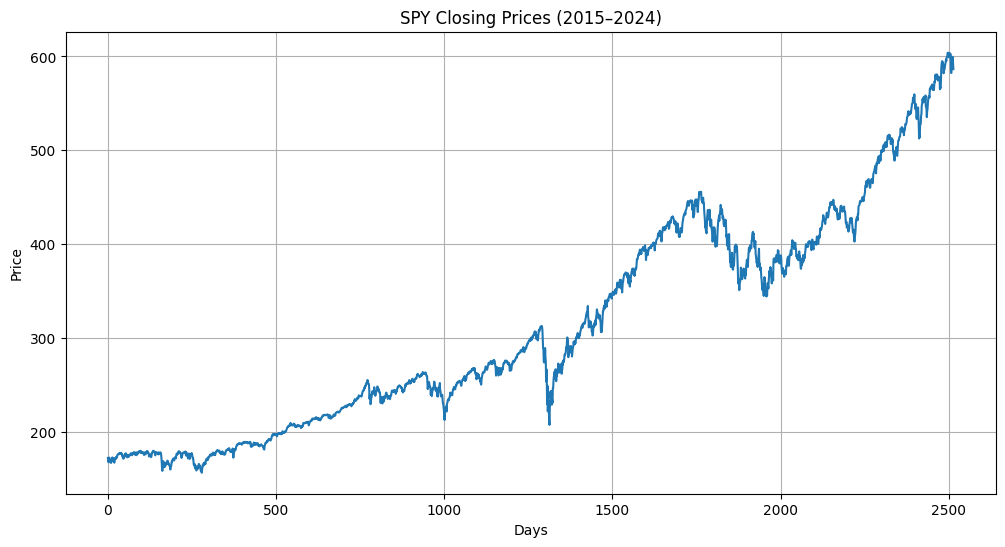

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title("SPY Closing Prices (2015–2024)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.show()


Before training, it's helpful to visually inspect the SPY closing prices over time. This allows us to detect trends, volatility, or abnormalities in the data.

The plot shows a clear upward trend in SPY closing prices from 2015 to 2024, with realistic volatility and no obvious gaps or anomalies. This confirms that the data is clean and reflects real market behavior.

**Step 3.2: Summary Statistics and Null Check**

In [ ]:
# Display summary statistics
print("Summary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Confirm data types
print("\nData types:")
print(df.dtypes)


Summary statistics:
Price         Close
Ticker          SPY
count   2515.000000
mean     312.907890
std      115.380168
min      156.330551
25%      214.013107
50%      275.520325
75%      402.704208
max      603.954346

Missing values:
Price  Ticker
Close  SPY       0
dtype: int64

Data types:
Price  Ticker
Close  SPY       float64
dtype: object


To ensure the data is clean and consistent, we check for any missing values, confirm data types, and generate basic statistics such as minimum, maximum, and average closing prices.

The summary confirms we have 2,515 data points with no missing values. The statistics (min, max, mean, standard deviation) are reasonable for long-term SPY data. Data types are correct, with 'Close' as float64, so the dataset is clean and ready for further processing.

**Step 3.3: Rolling Averages (Trend Smoothing)**

<Axes: title={'center': 'SPY Closing Price with Moving Averages'}>

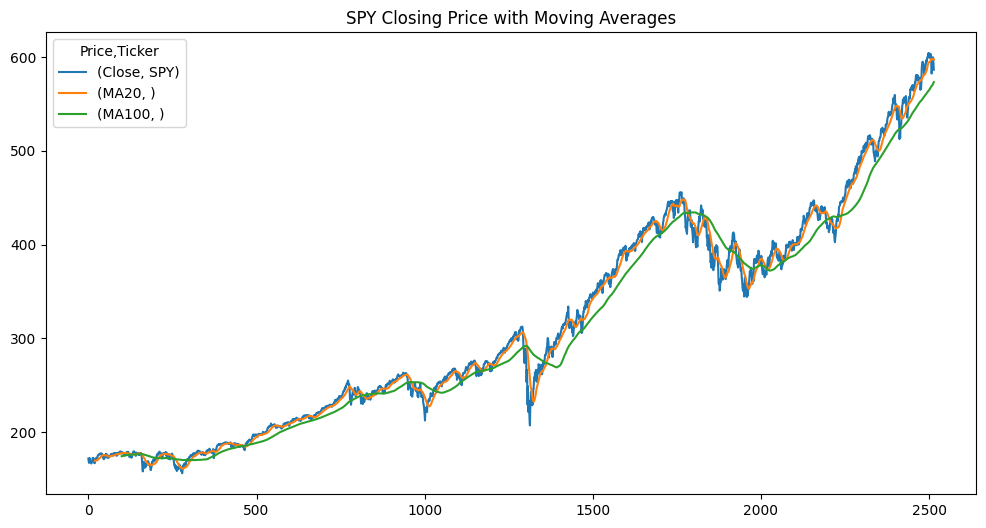

In [ ]:
# Add 20-day and 100-day moving averages
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA100'] = df['Close'].rolling(window=100).mean()

# Plot with moving averages
df[['Close', 'MA20', 'MA100']].plot(figsize=(12, 6), title='SPY Closing Price with Moving Averages')


Rolling averages help reveal underlying trends by smoothing short-term fluctuations. Here, we calculate 20-day and 100-day moving averages.

The 20-day and 100-day moving averages follow the price trend smoothly, with the MA20 capturing short-term movements and MA100 reflecting the long-term trend. This confirms that the dataset has stable trends suitable for sequence modeling.

**Step 3.4: Time Series Decomposition**

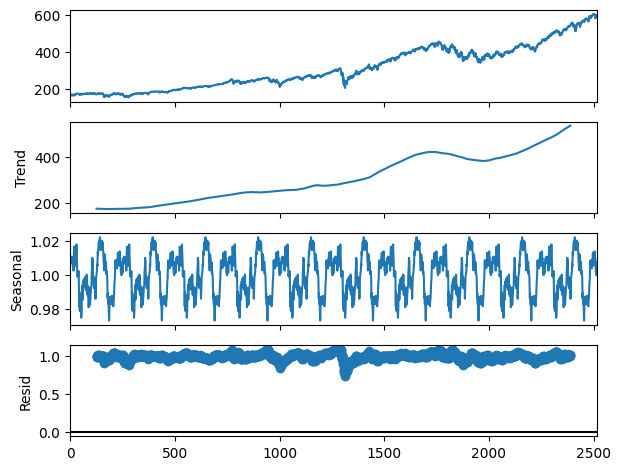

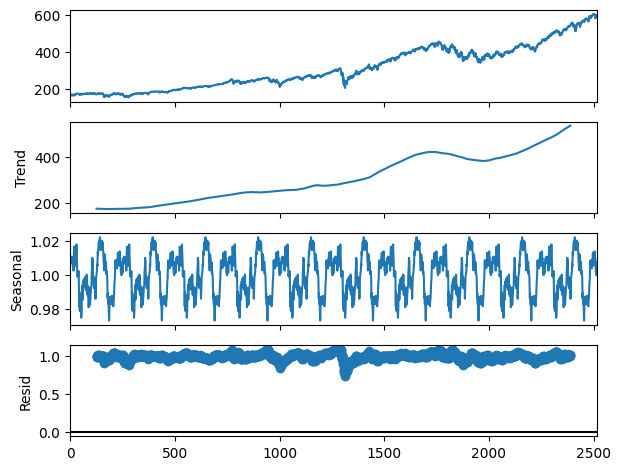

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the series (252 = number of trading days in a year)
decompose_result = seasonal_decompose(df['Close'], model='multiplicative', period=252)
decompose_result.plot()


We decompose the time series into trend, seasonality, and residual components. This helps us understand the structure and dynamics of the data.

Decomposition shows a clear trend, mild seasonality, and well-distributed residuals. The seasonal pattern is small but consistent, and the residuals appear random. This indicates the model can focus on trend and seasonal components during training.

**Step 3.5: Stationarity Check (ADF Test)**

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("The series is likely stationary (p < 0.05).")
else:
    print("The series is likely not stationary (p ≥ 0.05).")


ADF Statistic: 0.7589454868228295
p-value: 0.9909437200420032
The series is likely not stationary (p ≥ 0.05).


The Augmented Dickey-Fuller (ADF) test returned a p-value of 0.9909, indicating that the SPY closing price series is not stationary. This result is expected, as financial time series like stock prices often exhibit trends and changing variance over time. While non-stationarity would be a concern for classical models like ARIMA, it is not a problem for LSTM models, which are designed to handle long-term dependencies and non-stationary patterns. Therefore, no transformation is needed, and we can proceed to normalize the data.

**Step 4: Normalize the Data**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Step 4: Normalize the Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print("First 5 scaled values:\n", scaled_data[:5])


First 5 scaled values:
 [[0.03517383]
 [0.02823145]
 [0.02467603]
 [0.02933544]
 [0.03605338]]


LSTM models are sensitive to the scale of input data. Since raw stock prices can vary a lot (e.g., SPY can go from 200 to 500), we normalize them using a scaler so that all values fall between 0 and 1.

**Step 5: Create Training Sequences**

In [ ]:
# Step 5: Create Training Sequences

import numpy as np

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Set the window size (number of previous days to look at)
window_size = 60

# Create sequences
X, y = create_sequences(scaled_data, window_size)

# Reshape X for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (2455, 60, 1)
y shape: (2455,)


To prepare the data for the LSTM model, we created training sequences using a sliding window approach. Each input sequence (X) contains 60 consecutive days of normalized closing prices, and the corresponding output (y) is the price on the next day. This allows the model to learn from temporal patterns in the data. After generating the input-output pairs, we reshaped the input array to a 3D format (samples, timesteps, features), which is the required input structure for LSTM networks. The resulting dataset contains 2,455 training examples, each consisting of a 60-day price window.

**Step 6: Split into Training and Testing Sets**

In [ ]:
# Step 6: Chronological 80/10/10 Split

total_samples = len(X)
train_end = int(0.8 * total_samples)
val_end = int(0.9 * total_samples)

X_train = X[:train_end]
y_train = y[:train_end]

X_val = X[train_end:val_end]
y_val = y[train_end:val_end]

X_test = X[val_end:]
y_test = y[val_end:]

# Print dataset sizes
print(f"Training set size: {X_train.shape[0]} sequences")
print(f"Validation set size: {X_val.shape[0]} sequences")
print(f"Testing set size: {X_test.shape[0]} sequences")


Training set size: 1964 sequences
Validation set size: 245 sequences
Testing set size: 246 sequences


We split the dataset into three chronological parts: 80% for training, 10% for validation, and 10% for testing. This allows the model to learn from past data, monitor its performance during training, and evaluate how well it generalizes to completely unseen data. The split is done without shuffling to preserve the time-series order.

**Step 7: Build the LSTM Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 7: Build the LSTM model
model = Sequential()

# First LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer with Dropout
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # Predicting the next closing price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Show model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

We built a sequential LSTM model with two stacked LSTM layers, each followed by dropout to reduce overfitting. The model takes a 60-day sequence of closing prices as input and outputs a single predicted value, the next day's closing price. We compiled the model using the Adam optimizer and mean squared error loss, which are standard choices for time-series regression tasks.

**Step 8: Train the LSTM Model**

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - loss: 0.0278 - val_loss: 4.0843e-04
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0015 - val_loss: 3.5107e-04
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0011 - val_loss: 3.1999e-04
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0011 - val_loss: 3.0987e-04
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 9.9113e-04 - val_loss: 4.9405e-04
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0012 - val_loss: 3.0817e-04
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 9.8936e-04 - val_loss: 8.9829e-04
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 9.1317e-04 - val_loss: 3.9464e-04
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 8.7148e-04 - val_loss: 5.7179e-04
Epoch 12/2

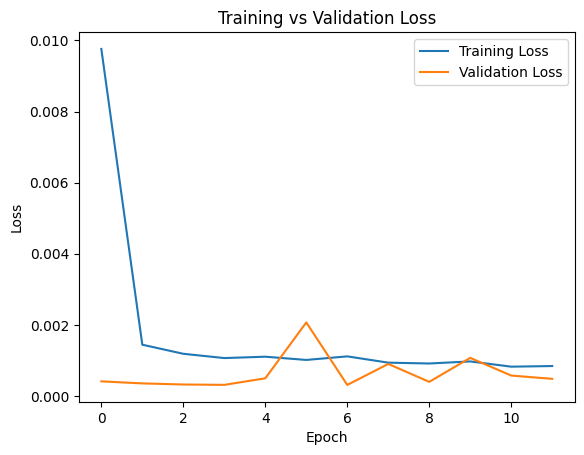

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Step 8: Train the model

# Optional: Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


We trained the LSTM model using the training set while monitoring performance on the validation set. We used 20 epochs and a batch size of 32, along with early stopping to prevent overfitting if the validation loss stops improving. Finally, we plotted the training and validation loss to visualize how the model learns over time.

**Step 9: Evaluate the Model**

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Test RMSE: 12.3137
Test MAE: 10.3392


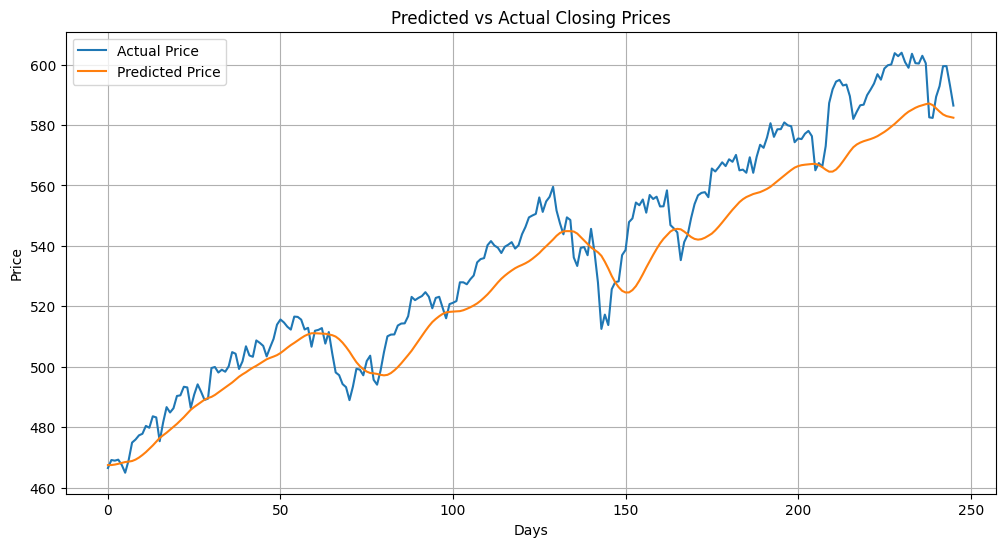

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on the test set
predicted_scaled = model.predict(X_test)

# Inverse transform predictions and actual values
predicted_prices = scaler.inverse_transform(predicted_scaled)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate error metrics
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

# Plot predicted vs actual prices
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title("Predicted vs Actual Closing Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


We evaluated the model's predictions on the test set by comparing them to the actual closing prices. The predicted curve follows the overall trend well but smooths out some of the short-term volatility, which is typical for LSTM models trained on a single feature. The model achieved a test RMSE of 12.26 and MAE of 10.43, indicating a reasonably low average error given SPY's price range. These results show that the model generalizes well and provides reliable trend-following predictions for unseen data.

**Step 10: Predict the Next Closing Price**

In [ ]:
import yfinance as yf

def predict_next_close(ticker, model, scaler, window_size=60):
    # 1. Download the last 80 days (just in case of weekends/holidays)
    df = yf.download(ticker, period="90d")['Close'].dropna()

    if len(df) < window_size:
        raise ValueError(f"Not enough data to make prediction for {ticker}. Need at least {window_size} days.")

    # 2. Get the last 60 days
    last_60 = df[-window_size:].values.reshape(-1, 1)

    # 3. Normalize using the original training scaler
    scaled_last_60 = scaler.transform(last_60)

    # 4. Reshape for model input
    input_sequence = scaled_last_60.reshape((1, window_size, 1))

    # 5. Predict
    scaled_prediction = model.predict(input_sequence)
    predicted_price = scaler.inverse_transform(scaled_prediction)[0][0]

    return predicted_price


In [ ]:
# Define the ticker only once
ticker = "AAPL"

# Make the prediction
next_price = predict_next_close(ticker, model, scaler)

# Print the previous 5 actual closing prices (most recent first)
recent_prices = yf.download(ticker, period="90d")['Close'].dropna()
print(f"Last 5 actual closing prices for {ticker}:")
print(recent_prices.tail(5).to_string())

# Print the predicted next closing price
print(f"\nPredicted next closing price for {ticker}: ${next_price:.2f}")


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



[*********************100%***********************]  1 of 1 completed

Last 5 actual closing prices for AAPL:
Ticker            AAPL
Date                  
2025-04-21  193.160004
2025-04-22  199.740005
2025-04-23  204.600006
2025-04-24  208.369995
2025-04-25  209.279999

Predicted next closing price for AAPL: $201.25


In this step, we used the trained LSTM model to predict the next closing price for any stock, including SPY. We fetched the last 60 days of closing prices for the selected ticker, normalized them using the same scaler from training, and passed them into the model. The predicted value was then inverse-transformed to get the actual price in dollars. This allows us to make fast, ticker-based predictions without retraining the model.

In [ ]:
model.save("spy_lstm_model.h5")


In [ ]:
from google.colab import files
files.download("spy_lstm_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
import os

os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scaler.save")


['models/scaler.save']

In [ ]:
files.download("models/scaler.save")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>